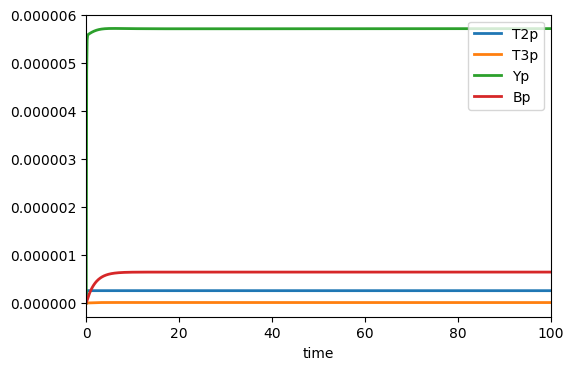

<module 'matplotlib.pyplot' from '/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

In [173]:
%matplotlib inline
from spiro_model import SpiroModel

spiro = SpiroModel()
rr = spiro.getRoadRunner()

#rr.timeCourseSelections = ['time', 'T2R', 'LT2', 'LT2p', 'Yp', 'T3R']
#rr.timeCourseSelections = ['time', 'LT2', 'LT3', 'LT2p', 'LT2R', 'LT4', 'Bp']
rr.timeCourseSelections = ['time', 'T2p', 'T3p','Yp', 'Bp']
end_time = 100
result = rr.simulate(0, end_time, 10*end_time)
rr.plot(result, xlim=[0, end_time])

In [116]:
rr.k1b

7000000.0

In [172]:
def getReactionRate(id):
  idx = rr.getReactionIds().index(id)
  return rr.getReactionRates()[idx]

ids = ['J10']
{id: getReactionRate(id) for id in ids}

{'J10': 5.6375725946066097e-11}

In [157]:
def getSpeciesAmount(id):
  idx = rr.getFloatingSpeciesIds().index(id)
  return rr.getFloatingSpeciesConcentrations()[idx]

ids = ['Yp']
{id: getSpeciesAmount(id) for id in ids}

{'Yp': 5.7896486169130341e-12}